# Generate examples of noise samples used in vision experiments

In [5]:
# import libraries and functions
import os  # handy system and path functions
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import random, repeat, zeros, linspace
from psychopy import gui, core
from PIL import Image


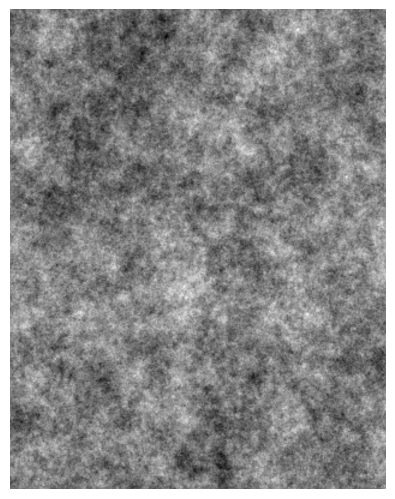

In [21]:
# Back up load a saved noise image
image = np.load('../noise_samples/pink_pink_0.npy')

fig = plt.figure(frameon=False) # show image without axes

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(image, cmap="gray")

fig.savefig("../noise_samples/pink_noise")

In [ ]:
expInfo = {'image_height_pix': 100,
           'image_width_pix': 100,
           'noise_type':['white', 'pink'],
           'pixel_scale':1,
           'interactive':[False, True]}

# Show pop-up for experimenter input
dlg = gui.DlgFromDict(dictionary=expInfo, sortKeys=False, title="Noise Generator")
if dlg.OK == False:
    core.quit()  # user pressed cancel

image_height_pix = expInfo["image_height_pix"]
image_width_pix = expInfo["image_width_pix"]
noise_type = expInfo["noise_type"]
pixel_scale = expInfo["pixel_scale"] # the resolution of the noise
interactive = expInfo["interactive"]

In [ ]:
# Step 1) Generate White Noise ====================================================================================================
im_size = int(max(image_height_pix, image_width_pix)) # we can trim the longer axis after but we start with a square noise stimulus # we used to add 1 here I think it has to do with the nyquist frequency
im_noise  = zeros([im_size,im_size])
nyquist_f = im_size/2.0 # The Nyquist Frequency is 1/2 of the sampling rate
# Creating an equally spaced array from -nyquistF to +nyquistF
f_arr = linspace(-nyquist_f,nyquist_f,im_size)

white_noise_original = random.standard_normal((im_size, im_size)) # draw samples from a standard Normal distribution (mean=0, stdev=1).

#plt.imshow(white_noise_original)

# scale by pixelScale
white_noise_scaled = repeat(white_noise_original, pixel_scale, axis=1)
white_noise_scaled = repeat(white_noise_scaled, pixel_scale, axis=0)

# trim noise to be the right size
noise = white_noise_scaled[0:im_size, 0:im_size]

fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,10),sharex=True,sharey=True)
ax = axes[0]
ax.set_title("Original Noise", fontsize=10, fontweight='bold')
ax.imshow(white_noise_original)

ax = axes[1]
ax.set_title("Scaled Noise", fontsize=10, fontweight='bold')
ax.imshow(white_noise)

# Step 2) If Pink Noise is Needed, We Filter the Noise ===============================================================================
if noise_type == "pink":
    exponent  = 1
    [f_x,f_y] = meshgrid(f_arr,f_arr)
    f_r       = abs((f_x**2.0 + f_y**2.0)**0.5)
    scale     = zeros([im_size,im_size])
    denom     = (f_r**exponent)
    scale[denom!=0] = 1.0/denom[denom!=0]

    noise = apply_filter(white_noise, pixel_scale)

# Step 3) Trim the Noise to Desired Size, and 
trimmed_noise = noise[0:image_width_pix, 0:image_height_pix]
trimmed_noise = trimmed_noise - mean(trimmed_noise.flat) # this code normalizes the noise, setting the mean to 0 and standard deviation to 1
trimmed_noise = (trimmed_noise / std(trimmed_noise.flat))

# Step 3) Save and Return the Noise Samples ==========================================================================================

In [ ]:
# Function to generate the noise
def two_dimensional_noise_generator(image_height_pix, image_width_pix, pixel_scale):
    """
    Given an array noiseProperties, int imSize, and int stimDurInFrames,
    returns a 2D array representing a certain type of noise.

    Currently stimDurInFrames must == imSize
    """
    im_size = 1+int(max(image_height_pix, image_width_pix)) # we can trim the longer axis after but we start with a square noise stimulus
    im_noise  = zeros([im_size,im_size])
    nyquist_f = im_size/2.0 # The Nyquist Frequency is 1/2 of the sampling rate
    # Creating an equally spaced array from -nyquistF to +nyquistF
    f_arr = linspace(-nyquist_f,nyquist_f,im_size)

    white_noise_original = random.standard_normal(im_size, im_size) # draw samples from a standard Normal distribution (mean=0, stdev=1).

    # scale by pixelScale
    white_noise_scaled = repeat(white_noise_original, pixel_scale, axis=1)
    white_noise_scaled = repeat(white_noise_scaled, pixel_scale, axis=0)
    # trim noise to be the right size
    white_noise = white_noise_scaled[0:im_size, 0:im_size]

    # set up pink noise filter
    exponent  = 1
    [f_x,f_y] = meshgrid(f_arr,f_arr)
    f_r       = abs((f_x**2.0 + f_y**2.0)**0.5)
    scale     = zeros([im_size,im_size])
    denom     = (f_r**exponent)
    scale[denom!=0] = 1.0/denom[denom!=0]

    if noise_properties['spatial_noise_type'] == noise_properties['temporal_noise_type'] or noise_properties['temporal_noise_type'] == 'constant':
        if noise_properties['spatial_noise_type'] == 'white':  # 2D white noise
            im_noise = white_noise
        elif noise_properties['spatial_noise_type'] == 'pink': # 2D pink noise
            im_noise = apply_filter(white_noise, scale)
        
        if noise_properties['temporal_noise_type'] == 'constant':
        # than all columns are just a copy of the first column
            im_noise = repeat(im_noise[:,[0]], im_size, axis=1)
    else: # noise is pink along one dimension and white along the other
        im_noise = empty([im_size,im_size])

        for i in range(0,im_size):
            # grab a slice of white noise
            white_noise_col = white_noise[i,:] # I think this is technically a row
            # filter it to be pink noise
            pink_noise_col = apply_one_dim_filter(white_noise_col)
            im_noise[i,:] = pink_noise_col
        if noise_properties['temporal_noise_type'] == 'white': # axis 1 is time
            im_noise = rot90(im_noise)

    # trim the longer axis
    assert type(im_size) == int
    assert type(stim_dur_in_frames) == int

    im_trim_noise = im_noise[0:im_size-1, 0:stim_dur_in_frames]
    im_trim_noise = im_trim_noise - mean(im_trim_noise.flat)
    im_trim_noise = (im_trim_noise / std(im_trim_noise.flat))

    return im_trim_noise

In [ ]:
def reload_exp_properties(dBRMS_noise_contrast, temporal_plateau_width_secs, spatial_noise, temporal_noise, settings_filepath):
    expInfo = {
           'temporalPlateauWidthSeconds' : temporal_plateau_width_secs, 
           'dBRMSNoiseContrast' : dBRMS_noise_contrast,
           'spatial_noise_type': spatial_noise,
           'temporal_noise_type': temporal_noise,
           'gratingType' : 'sin'
           }
    stimulus_properties = load_stimulus_properties(settings_filepath, expInfo)
    noise_properties = {'spatial_noise_type':stimulus_properties['spatial_noise_type'], 'temporal_noise_type': stimulus_properties['temporal_noise_type'] ,'pixelScale':2}

    return stimulus_properties, noise_properties

def generate_noise(dBRMS_noise_contrast, temporal_plateau_width_secs, constant_to_add_to_seed, spatial_noise_condition, temporal_noise_condition, settings_filepath):
    stimulus_properties, noise_properties =  reload_exp_properties(dBRMS_noise_contrast, temporal_plateau_width_secs, spatial_noise_condition, temporal_noise_condition, settings_filepath) # reload settings 
    random_seed = random_seed_gen(constant_to_add_to_seed) # generate random seed
    noise_image = two_dimensional_noise_generator(stimulus_properties['imSizePix'], noise_properties, stimulus_properties['temporalPresentationTimeFrames'], random_seed) # TODO: check where temporal plateau width plays a role

    return random_seed, noise_image, stimulus_properties